In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
df = data.drop('PassengerId', axis= 1).copy()

In [4]:
df.groupby(['Pclass', 'Sex'])['Age'].median()

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

# EDA

In [5]:
## Data is unbalanced
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

#### Sex

In [6]:
## Here we see a nice thing
df.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

#### Age

In [7]:
df.groupby('Survived')['Age'].mean()

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

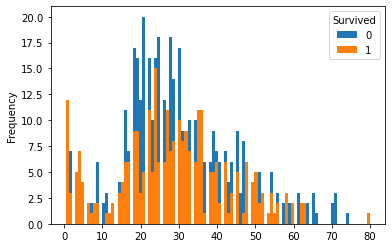

In [8]:
## we see that most of child survived
df.pivot(columns="Survived", values="Age").plot.hist(bins=100)
plt.show()

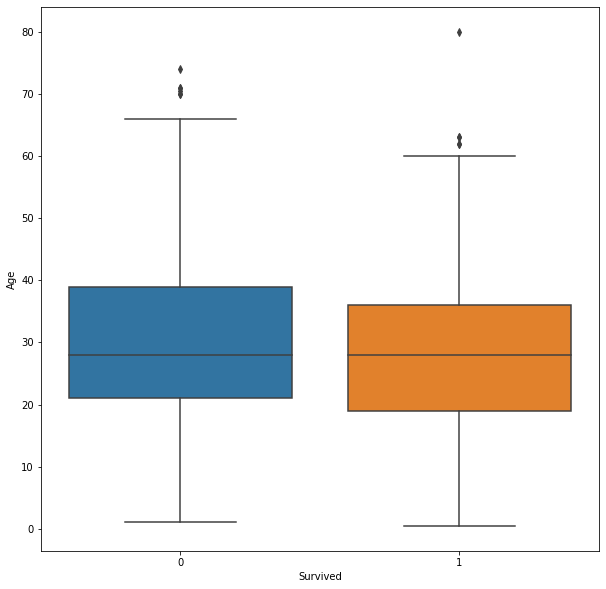

In [9]:
plt.figure(figsize=(10,10))
sns.boxplot(data= df , y='Age' , x='Survived')
plt.show()


In [10]:
df.groupby(['Survived','Sex']).agg({'Age' : 'mean' , 'Name' : 'count'})

Age  Name
Survived Sex                    
0        female  25.046875    81
         male    31.618056   468
1        female  28.847716   233
         male    27.276022   109

In [11]:
df.groupby(['Sex']).agg({'Age' : 'mean' , 'Name' : 'count'})

,Age,Name
Sex,,
female,27.915709,314
male,30.726645,577


#### Fare

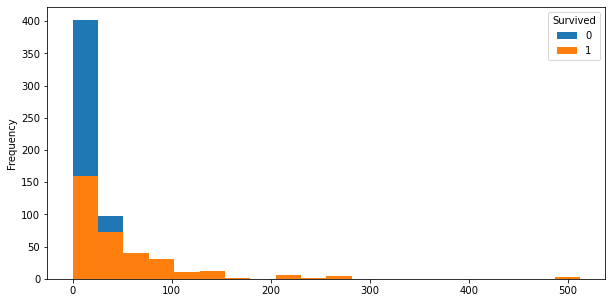

In [12]:
df.pivot(columns="Survived", values="Fare").plot.hist( figsize =(10,5) , bins = 20)
plt.show()

In [13]:
## the richier the passenger, greater his chance of surviving
df.groupby('Survived')['Fare'].mean()

Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64

In [14]:
#temp = df.copy()
df['FareGroup'] = pd.cut(df['Fare'] ,bins= [-1,20,50,100,1000] , labels= [1,2,3,4])
df.groupby('FareGroup')['Survived'].mean()

FareGroup
1    0.277670
2    0.416667
3    0.654206
4    0.735849
Name: Survived, dtype: float64

In [15]:
df.groupby('Parch')['Age'].mean()

Parch
0    32.178503
1    24.422000
2    17.216912
3    33.200000
4    44.500000
5    39.200000
6    43.000000
Name: Age, dtype: float64

#### Position

In [16]:
df['Fnc'] = df['Name'].map(lambda x : x.split(',')[1].strip().split('.')[0])


In [17]:
names = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr':    'Officer',
    'Rev':      'Officer',
    'Mlle':     'Miss',
    'Major':       'Officer',
    'Col':     'Officer',
    'the Countess':  'Miss',
    'Capt':   'Officer',
    'Ms':   'Mrs',
    'Sir':   'Mr',
    'Lady':   'Miss',
    'Mme': 'Mrs',
    'Don':  'Mr',
    'Jonkheer':    'Master'
}


In [18]:
df['Position'] = df['Fnc'].map(names)

In [19]:
df.groupby(['Position'])[['Age',   'Fare']].median()

,Age,Fare
Position,,
Master,4.0,29.0000
Miss,21.5,17.3500
Mr,30.0,9.4833
Mrs,35.0,26.0000
Officer,50.0,26.5500


In [20]:
dfImputers = df.groupby(['Position'])[['Age',   'Fare']].median()

In [21]:
df.groupby(['Position'])['Survived'].mean()

Position
Master     0.560976
Miss       0.704301
Mr         0.157996
Mrs        0.795276
Officer    0.277778
Name: Survived, dtype: float64

In [22]:
df['Age'] = df['Age'].fillna(df.merge(dfImputers, left_on='Position' , right_index=True)['Age_y'])
df['Fare'] = df['Fare'].fillna(df.merge(dfImputers, left_on='Position' , right_index=True)['Fare_y'])

#### Family

In [23]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'FareGroup', 'Fnc', 'Position'],
      dtype='object')

In [24]:
df['Family'] = df[['SibSp','Parch']].sum(axis=1)

#### Embarked

In [25]:
dfEmbarked = pd.DataFrame(df.groupby('Embarked')['Survived'].mean()).rename(columns={'Survived' : 'Embarked'})

In [26]:
df['Embarked'] = df.merge(dfEmbarked, left_on='Embarked' , right_index=True)['Embarked_y']

#### Cabin

In [27]:
df['Cabin'] = df['Cabin'].map(lambda x : 0 if pd.isnull(x) else 1 )
df.groupby('Cabin')['Survived'].mean()

Cabin
0    0.299854
1    0.666667
Name: Survived, dtype: float64

# Pre Processamento

In [28]:
PositionEncoder = OneHotEncoder()

In [29]:
PositionEncoder.fit(df[['Position']])

OneHotEncoder()

In [30]:
df = df.join(pd.DataFrame(PositionEncoder.transform(df[['Position']]).toarray(), columns=PositionEncoder.get_feature_names_out(), index = df.index))

# Fim

In [31]:
feat = ['Survived' ,'Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare','Cabin', 'Position_Master'	,'Position_Miss',	'Position_Mr',	'Position_Mrs']
x= df[feat].dropna()

In [32]:
x['Sex'] = x['Sex'].map(lambda x : 1 if x =='female' else 0)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x.drop('Survived' , axis = 1) , x['Survived'], test_size=0.2, random_state=42)

In [34]:
r =RandomForestClassifier(criterion='entropy' , n_estimators=100 ,n_jobs=-1, max_depth=8, random_state=42)
r.fit(x_train , y_train)
r.score(x_test , y_test)

0.8212290502793296

In [35]:
y_test.value_counts()

0    105
1     74
Name: Survived, dtype: int64

In [36]:
confusion_matrix(y_test, r.predict(x_test))

array([[92, 13],
       [19, 55]], dtype=int64)

In [37]:
temp = x_test.copy()

In [38]:
temp['real'] = y_test
temp['previsto'] = r.predict(x_test)

In [39]:
temp[(temp['real']==1) & (temp['previsto']==0)]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Position_Master,Position_Miss,Position_Mr,Position_Mrs,real,previsto
39,3,1,14.0,1,0,11.2417,0,0.0,1.0,0.0,0.0,1,0
621,1,0,42.0,1,0,52.5542,1,0.0,0.0,1.0,0.0,1,0
447,1,0,34.0,0,0,26.5500,0,0.0,0.0,1.0,0.0,1,0
192,3,1,19.0,1,0,7.8542,0,0.0,1.0,0.0,0.0,1,0
673,2,0,31.0,0,0,13.0000,0,0.0,0.0,1.0,0.0,1,0
204,3,0,18.0,0,0,8.0500,0,0.0,0.0,1.0,0.0,1,0
23,1,0,28.0,0,0,35.5000,1,0.0,0.0,1.0,0.0,1,0
889,1,0,26.0,0,0,30.0000,1,0.0,0.0,1.0,0.0,1,0
712,1,0,48.0,1,0,52.0000,1,0.0,0.0,1.0,0.0,1,0
338,3,0,45.0,0,0,8.0500,0,0.0,0.0,1.0,0.0,1,0


In [40]:
df[df.index.isin(temp[(temp['real']==1) & (temp['previsto']==0)].index)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FareGroup,Fnc,Position,Family,Position_Master,Position_Miss,Position_Mr,Position_Mrs,Position_Officer
23,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,1,0.336957,2,Mr,Mr,0,0.0,0.0,1.0,0.0,0.0
25,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,0,0.336957,2,Mrs,Mrs,6,0.0,0.0,0.0,1.0,0.0
39,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,0,0.553571,1,Miss,Miss,1,0.0,1.0,0.0,0.0,0.0
97,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,1,0.553571,3,Mr,Mr,1,0.0,0.0,1.0,0.0,0.0
109,1,3,"Moran, Miss. Bertha",female,21.5,1,0,371110,24.1500,0,0.389610,2,Miss,Miss,1,0.0,1.0,0.0,0.0,0.0
192,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,0,0.336957,1,Miss,Miss,1,0.0,1.0,0.0,0.0,0.0
204,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.0500,0,0.336957,1,Mr,Mr,0,0.0,0.0,1.0,0.0,0.0
209,1,1,"Blank, Mr. Henry",male,40.0,0,0,112277,31.0000,1,0.553571,2,Mr,Mr,0,0.0,0.0,1.0,0.0,0.0
286,1,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.5000,0,0.336957,1,Mr,Mr,0,0.0,0.0,1.0,0.0,0.0
338,1,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,0,0.336957,1,Mr,Mr,0,0.0,0.0,1.0,0.0,0.0


## Predict

In [41]:
test['Sex'] = test['Sex'].map(lambda x : 1 if x =='female' else 0)

In [42]:
test['Fnc'] = test['Name'].map(lambda x : x.split(',')[1].strip().split('.')[0])
test['Position'] = test['Fnc'].map(names)

In [43]:
test['Age'] = test['Age'].fillna(test.merge(dfImputers, left_on='Position' , right_index=True)['Age_y'])
test['Fare'] = test['Fare'].fillna(test.merge(dfImputers, left_on='Position' , right_index=True)['Fare_y'])
test['Embarked'] = test.merge(dfEmbarked, left_on='Embarked' , right_index=True)['Embarked_y']
test['isAlone'] = test[['SibSp','Parch']].sum(axis=1).map(lambda x : 1 if x >0 else 0)
test['Cabin'] = test['Cabin'].map(lambda x : 0 if pd.isnull(x) else 1 )

In [44]:
test['Position'] = test['Position'].fillna('Mr')

In [45]:
test = test.join(pd.DataFrame(PositionEncoder.transform(test[['Position']]).toarray(), columns=PositionEncoder.get_feature_names_out(), index = test.index))

In [46]:
test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Embarked', 'Cabin', 'isAlone', 'Position_Master'	,'Position_Miss',	'Position_Mr',	'Position_Mrs']]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin,isAlone,Position_Master,Position_Miss,Position_Mr,Position_Mrs
0,3,0,34.5,0,0,7.8292,0.389610,0,0,0.0,0.0,1.0,0.0
1,3,1,47.0,1,0,7.0000,0.336957,0,1,0.0,0.0,0.0,1.0
2,2,0,62.0,0,0,9.6875,0.389610,0,0,0.0,0.0,1.0,0.0
3,3,0,27.0,0,0,8.6625,0.336957,0,0,0.0,0.0,1.0,0.0
4,3,1,22.0,1,1,12.2875,0.336957,0,1,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,30.0,0,0,8.0500,0.336957,0,0,0.0,0.0,1.0,0.0
414,1,1,39.0,0,0,108.9000,0.553571,1,0,0.0,0.0,1.0,0.0
415,3,0,38.5,0,0,7.2500,0.336957,0,0,0.0,0.0,1.0,0.0
416,3,0,30.0,0,0,8.0500,0.336957,0,0,0.0,0.0,1.0,0.0


In [47]:
pd.DataFrame(r.predict(test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Cabin', 'Position_Master'	,'Position_Miss',	'Position_Mr',	'Position_Mrs']]) , index = test['PassengerId'], columns=['Survived']).to_csv('pred.csv')

In [48]:
test.groupby('Sex').size()

Sex
0    266
1    152
dtype: int64